<div align="center">
<h1>Prédiction du prix des billets d'avion</h1>
</div>

L'objectif de ce projet est de prédire le prix des billets d'avion en fonction de diverses caractéristiques telles que la date de réservation, la durée du vol, le nombre d'escales, etc. Nous allons effectuer une analyse exploratoire des données (EDA) pour comprendre les relations entre les différentes variables et le prix des billets. Ensuite, nous construirons un modèle prédictif pour estimer le prix des billets en fonction des caractéristiques disponibles.
L’objectif est d'être capable de prédire le prix des billets d’avion avec une erreur moyenne raisonnable. Plus précisément, on cherchera à obtenir une erreur absolue moyenne (MAE) inférieure à 15 €, tout en quantifiant l’incertitude associée à cette estimation à l’aide d’un intervalle de confiance.

# Index

- [**Les données**](#donnees)
- [**Analyse technique**](#analyse-technique)
  - [**Analyse univariée**](#analyse-univariee)
  - [**Analyse multivariée**](#analyse-multivariee)
- [**Formuler et tester des hypothèses**](#formuler-et-tester-des-hypotheses)
- [**Preprocessing**](#preprocessing)
- [**Modélisation**](#Modelisation)
- [**Évaluation finale du modèle**](#evaluation-finale-du-modele)

# Import

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, KFold

<a id="donnees"></a>

# Données et analyse fondamentale

Le dataset provient de Kaggle, et est disponible [ICI](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction), c'est le dataset `Clean_Dataset.csv`. 

**Quoi** : Un total de `300.261` réservations de vol distinctes a été extrait du site et couvrent des vols programmés entre les 6 plus grandes villes d'Inde. Le dataset est une version nettoyée du dataset brut.

**Quand** : Données collectées sur une période de 50 jours, du 11 février au 31 mars 2022

**Où** : Les données proviennent du site web `Ease my trip`

**Comment** : Scrapping avec l'outils Octoparse. Les données ont été collectées en deux parties : une pour les billets de classe économique et une autre pour les billets de classe affaires. 


On utilise `read_csv` de pandas pour le lire.

In [98]:
original_df = pd.read_csv('Data/Clean_Dataset.csv')

In [99]:
original_df.shape

(300153, 12)

**Description des colonnes :**

- airline : Nom de la compagnie aérienne.
- flight : Code du vol.
- source_city : Ville de départ.
- departure_time : Heure de départ (catégorisée: Morning, Afternoon, ...).
- stops : Nombre d'escales (zero, one, two_or_more).
- arrival_time : Heure d'arrivée (catégorisée: Morning, Afternoon, ...).
- destination_city : Ville d'arrivée.
- class : Classe du billet (économique ou business).
- duration : Durée du vol (en heures).
- days_left : Nombre de jours entre la date de réservation et la date du vol.
- price : Prix du billet (variable cible) en Roupie indienne.

Chaque ligne du dataset représente donc un vol avec ses caractéristiques et son prix associé.

In [100]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


---

<a id="analyse-technique"></a>

# Analyse technique du jeu de données

Avant toute analyse statistique, il faut comprendre **la nature exacte des variables** que nous avons entre les mains.  
Notre objectif ici est double :

1. **Identifier le type de chaque variable**  
   - Variable discrète ?  
   - Variable continue ?  
   - Date ? Texte libre ?  
   - Fausses quantités ? (ex : durée exprimée en `String`)

2. **Identifier ce que l’on peut faire avec chacune d’elles**  
   → Est-ce qu’on peut calculer des statistiques ?  
   → Est-ce qu’on peut compter des catégories ?  
   → Est-ce qu’on doit transformer des colonnes avant toute analyse ?

Cette étape sert à déterminer ce qui est faisable en analyse univariée et multivariée.

On commence donc par lister toutes les colonnes et examiner leur contenu.

In [101]:
# Aperçu des colonnes et des premiers éléments de chaque variable
original_df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


### Classification des variables (discrète / continue / autre)

À partir du type réel (`object`, `int`, etc.) et de l'observation des valeurs, on va classifier les variables de façon statistique.

- **Airline** → Discrète (catégorielle)
- **Flight** → Discrète (catégorielle)
- **Source_city** → Discrète (catégorielle)
- **Departure_time** → Discrète (catégorielle ordinale)
- **Stops** → Discrète (numérique ordinale)
- **Arrival_time** → Discrète (catégorielle ordinale)
- **Destination_city** → Discrète (catégorielle)
- **Class** → Discrète (catégorielle)
- **Duration** → Continue (numérique)
- **Days_left** → Continue (numérique)
- **Price** → Continue (numérique) - Variable cible

On vérifie maintenant l’unicité des catégories et une statistique simple sur les variables continues.

In [102]:
discrete_cols = ["airline", "flight", "source_city", "departure_time", "stops", "arrival_time", "destination_city", "class"]
continues_cols = ["duration", "days_left", "price"]

In [103]:
# Comptage rapide des catégories pour les variables discrètes
for col in discrete_cols:
    print(f"\n--- {col} ---")
    print(original_df[col].value_counts().head())


--- airline ---
airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
Name: count, dtype: int64

--- flight ---
flight
UK-706    3235
UK-772    2741
UK-720    2650
UK-836    2542
UK-822    2468
Name: count, dtype: int64

--- source_city ---
source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Name: count, dtype: int64

--- departure_time ---
departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Name: count, dtype: int64

--- stops ---
stops
one            250863
zero            36004
two_or_more     13286
Name: count, dtype: int64

--- arrival_time ---
arrival_time
Night            91538
Evening          78323
Morning          62735
Afternoon        38139
Early_Morning    15417
Name: count, dtype: int64

--- destination_city ---
destination_city
Mumbai       59097
Delhi        57360
Bangalore    51068
Ko

<a id="analyse-univariee"></a>

## Analyse Univariée

Maintenant que les variables ont été classées, on commence l’analyse statistique variable par variable.

L’objectif est ici :

- Pour les **variables discrètes** : lister les effectifs et visualiser les catégories majoritaires/minoritaires.  
- Pour les **variables continues** : voir la distribution, les valeurs extrêmes, les asymétries, etc.



In [104]:
def univ_analysis_discrete(col_name, max_unique=20):
    print(f"\n===== {col_name} =====")
    display(original_df[col_name].value_counts())
    # Bar plot
    plt.figure(figsize=(10, 5))
    if original_df[col_name].nunique() <= max_unique:
        original_df[col_name].value_counts().plot(kind='bar')
        plt.title(f"Distribution of {col_name}")
        plt.xlabel(col_name)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
    else:
        original_df[col_name].value_counts().nlargest(max_unique).plot(kind='bar')
        plt.title(f"Top {max_unique} categories of {col_name}")
        plt.xlabel(col_name)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
    plt.show()

def univ_analysis_continuous(col_name, nbins=30):
    print(f"\n===== {col_name} =====")
    display(original_df[col_name].describe())
    # box plot and histogram
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    original_df.boxplot(column=col_name)
    plt.title(f"Box plot pour {col_name}")
    plt.subplot(1, 2, 2)
    original_df[col_name].hist(bins=nbins)
    plt.title(f"Histograme pour {col_name}")
    plt.xlabel(col_name)
    plt.ylabel("Fréquence")
    plt.show()

### Price

On commence par la variable cible `Price`.


===== price =====


count    300153.000000
mean      20889.660523
std       22697.767366
min        1105.000000
25%        4783.000000
50%        7425.000000
75%       42521.000000
max      123071.000000
Name: price, dtype: float64

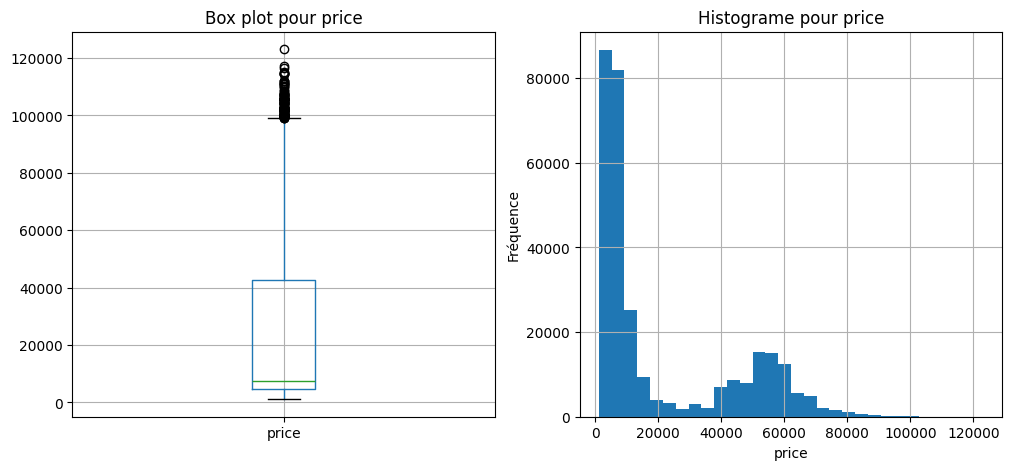

In [105]:
univ_analysis_continuous("price")

- La moyenne du prix est de 20800 Roupies, mais la médiane est à 7400 Roupies, ce qui indique une distribution asymétrique avec une longue queue à droite (quelques billets très chers). C'est ce qu'on observe dans l'histogramme.
- Les deux groupes de prix correspondent en fait aux classes économique et business.

### Airline


===== airline =====


airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64

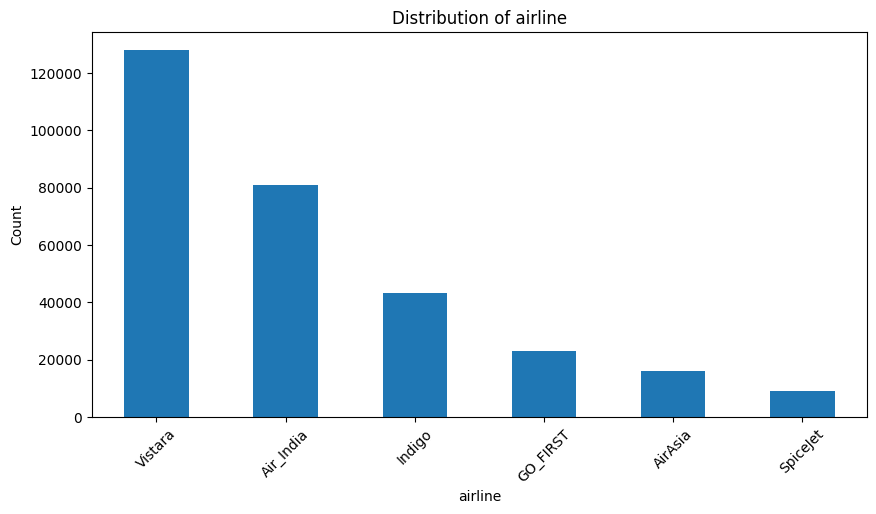

In [106]:
univ_analysis_discrete("airline")

- Variable **discrète**, à forte part de marché inégale.  
- Impact probable sur le prix → à analyser dans la partie *multivariée*.

### Source_city


===== source_city =====


source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64

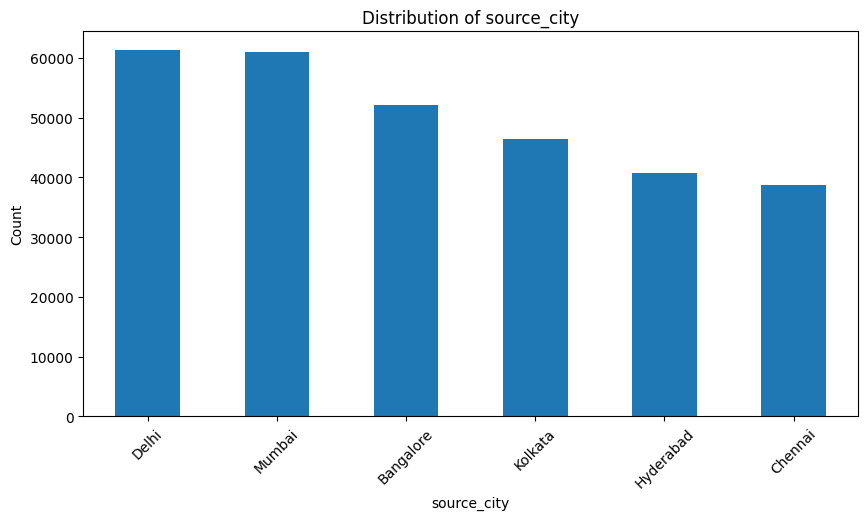

In [107]:
univ_analysis_discrete("source_city")

 - Peut fortement influencer le prix selon la destination → à explorer plus loin.

### Departure_time


===== departure_time =====


departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64

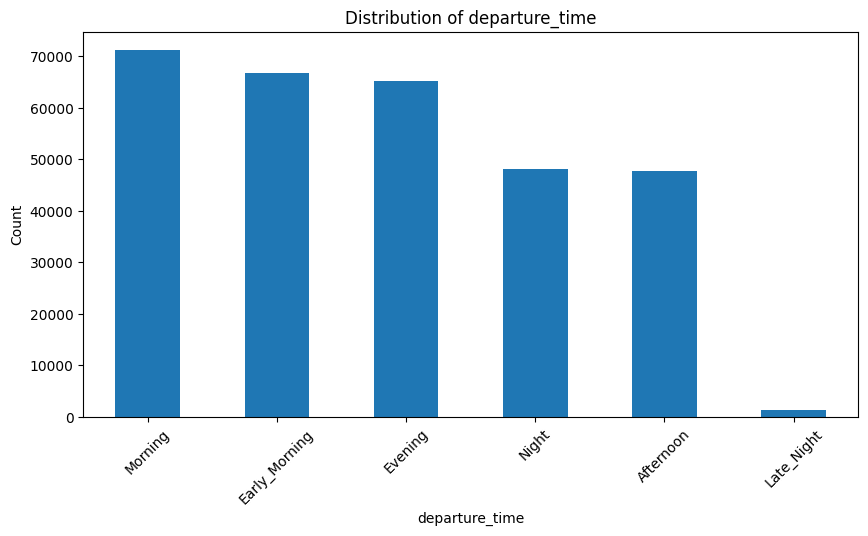

In [108]:
univ_analysis_discrete("departure_time")

- Très peu de vols tardifs

### Stops


===== stops =====


stops
one            250863
zero            36004
two_or_more     13286
Name: count, dtype: int64

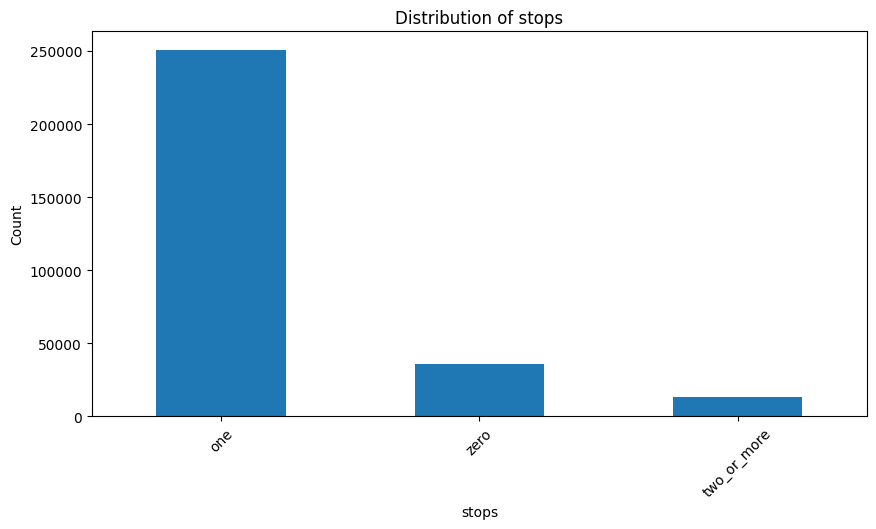

In [109]:
univ_analysis_discrete("stops")

- Variable **discrète ordinale** (zero/One/two_or_more stops). 
- À transformer en variable numérique ordonnée pour la modélisation.

### Arrival_time


===== arrival_time =====


arrival_time
Night            91538
Evening          78323
Morning          62735
Afternoon        38139
Early_Morning    15417
Late_Night       14001
Name: count, dtype: int64

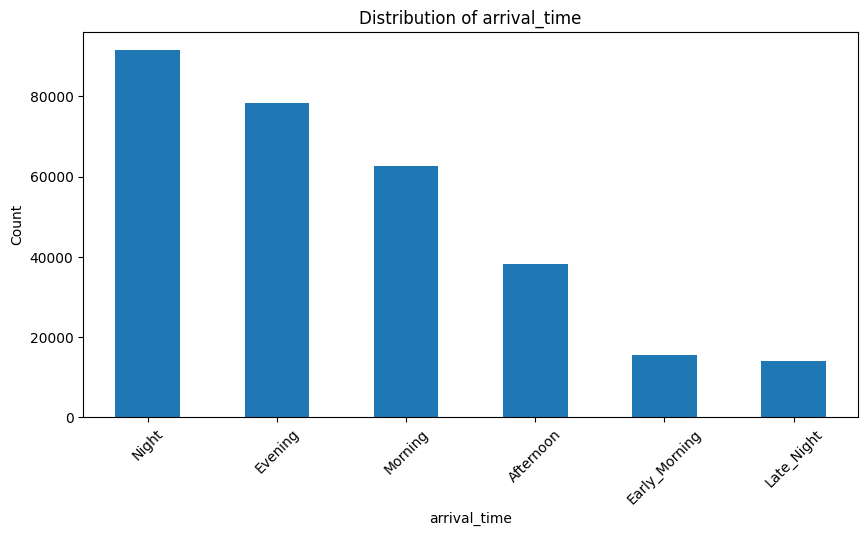

In [110]:
univ_analysis_discrete("arrival_time")

- Beaucoup de vols arrivent tard le soir ou la nuit.

### Destination_city


===== destination_city =====


destination_city
Mumbai       59097
Delhi        57360
Bangalore    51068
Kolkata      49534
Hyderabad    42726
Chennai      40368
Name: count, dtype: int64

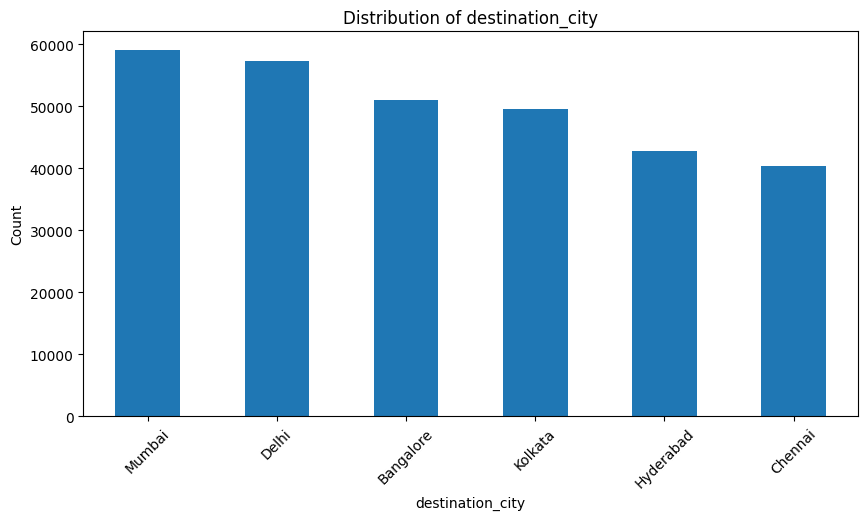

In [111]:
univ_analysis_discrete("destination_city")

### Class


===== class =====


class
Economy     206666
Business     93487
Name: count, dtype: int64

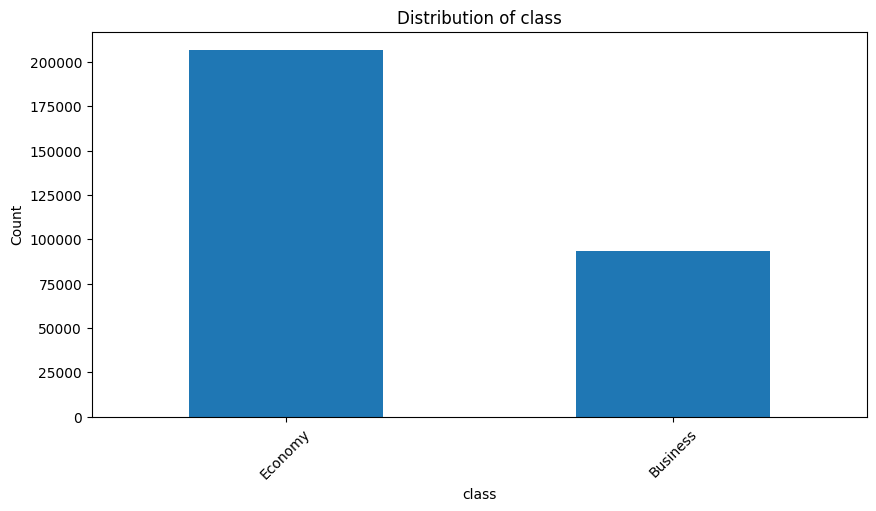

In [112]:
univ_analysis_discrete("class")

- À peu près deux fois plus de billets en classe économique qu'en classe business.

On poursuit avec l’analyse des **variables continues** du dataset.

### Duration


===== duration =====


count    300153.000000
mean         12.221021
std           7.191997
min           0.830000
25%           6.830000
50%          11.250000
75%          16.170000
max          49.830000
Name: duration, dtype: float64

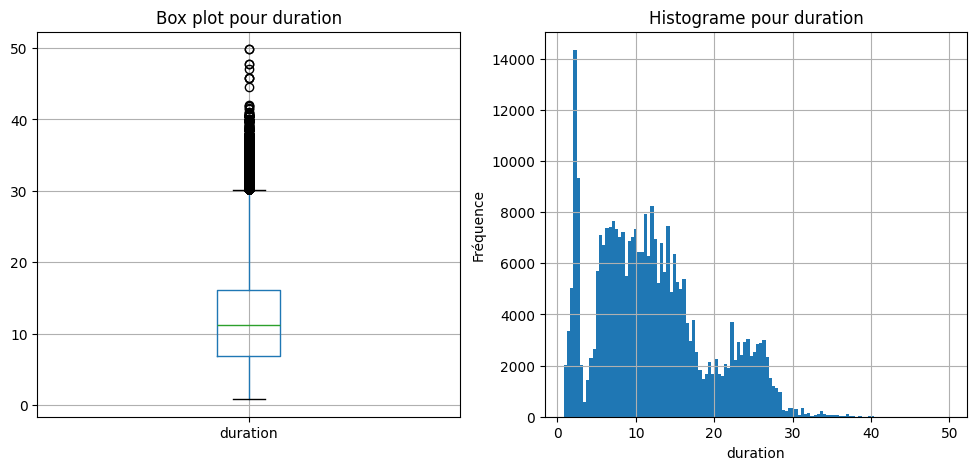

In [113]:
univ_analysis_continuous("duration", nbins=120)

### Days_left


===== days_left =====


count    300153.000000
mean         26.004751
std          13.561004
min           1.000000
25%          15.000000
50%          26.000000
75%          38.000000
max          49.000000
Name: days_left, dtype: float64

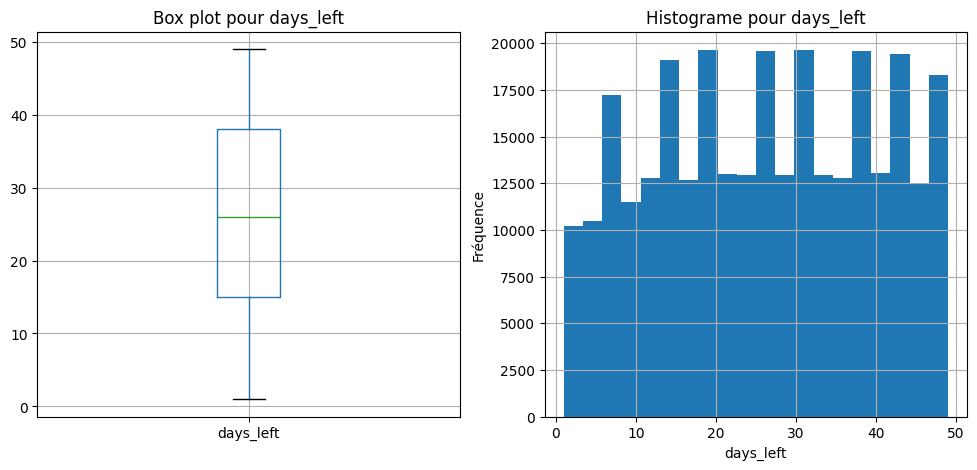

In [114]:
univ_analysis_continuous("days_left", nbins=20)

<a id="analyse-multivariee"></a>

## Analyse multivariée

On s'interesse maintenant aux relations entre les différentes variables. Notamment comment les variables influencent le prix des billets d'avion. 

### Relation entre la durée du vol et le prix

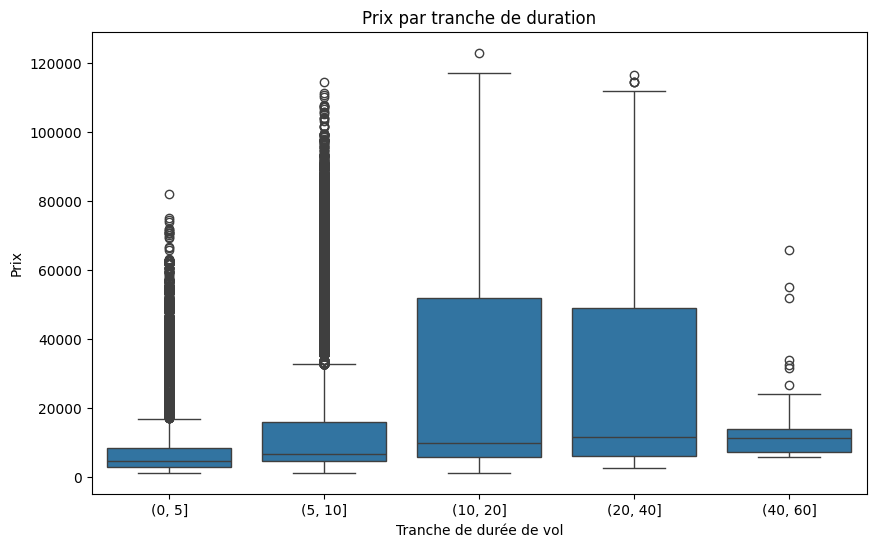

In [115]:
# On crée des tranches (bins)
original_df["duration_bin"] = pd.cut(original_df["duration"], bins=[0,5,10,20,40,60])
# original_df["price_bin"] = pd.cut(original_df["price"], bins=[0,20000,40000,60000,80000,100000,120000])
plt.figure(figsize=(10, 6))
sns.boxplot(data=original_df, x="duration_bin", y="price")
plt.title("Prix par tranche de duration")
plt.xlabel("Tranche de durée de vol")
plt.ylabel("Prix")
plt.show()

Ici, les prix moyens semblent varier positivement avec la durée du vol.

### Relation entre le prix et la compagnie aérienne

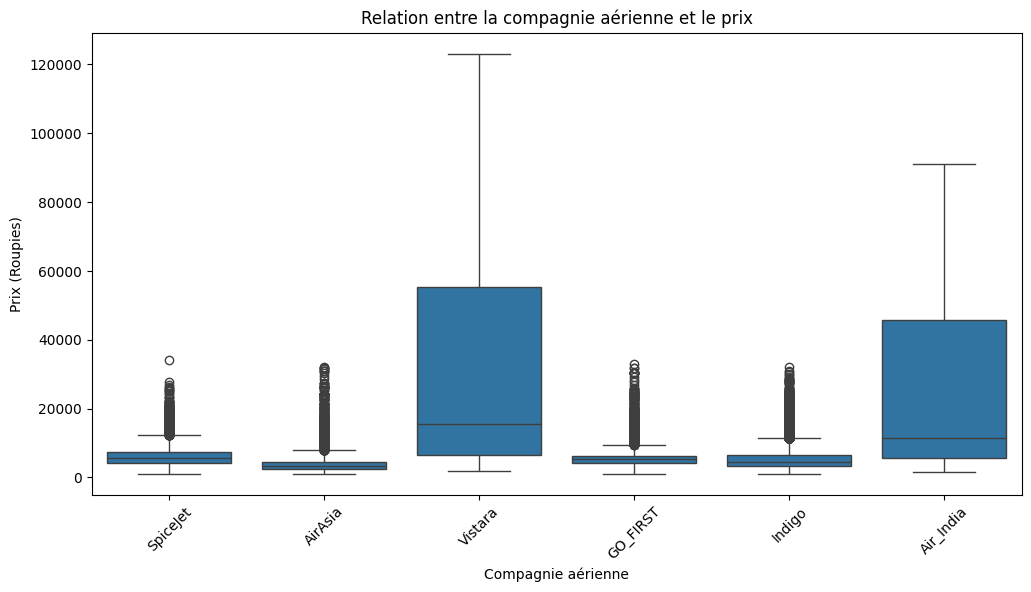

In [116]:
# Relation entre airline et price
plt.figure(figsize=(12, 6))
sns.boxplot(data=original_df, x="airline", y="price")
plt.title("Relation entre la compagnie aérienne et le prix")
plt.xlabel("Compagnie aérienne")
plt.ylabel("Prix (Roupies)")
plt.xticks(rotation=45)
plt.show()

On remarque des valeurs plus élevées pour certaines compagnies aériennes, ici Vistara et Air India, ce qui suggère que la compagnie propose un service premium par exemple.


La compagnie aérienne **semble** avoir un impact significatif sur le prix des billets d'avion.

### Relation entre le nombre d'escales et le prix

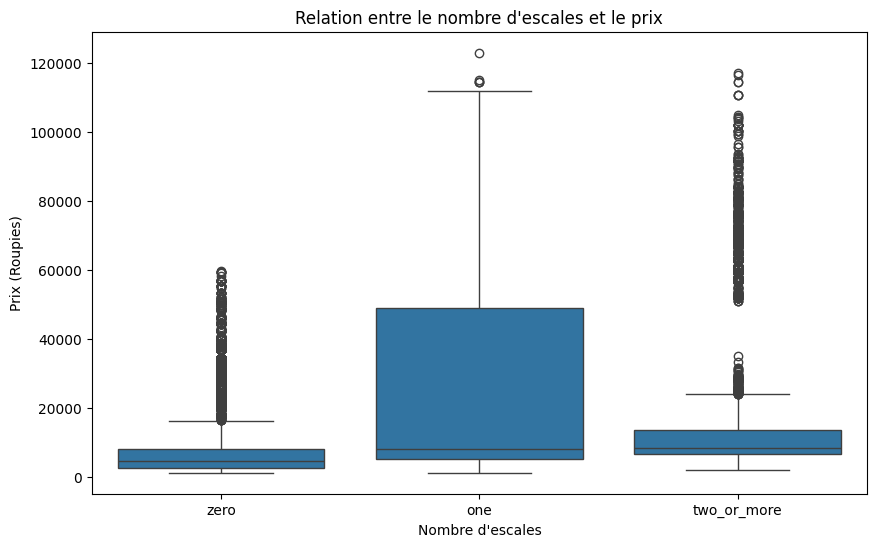

In [117]:
# Relation entre stops et price
plt.figure(figsize=(10, 6))
sns.boxplot(data=original_df, x="stops", y="price")
plt.title("Relation entre le nombre d'escales et le prix")
plt.xlabel("Nombre d'escales")
plt.ylabel("Prix (Roupies)")
plt.show()

En moyenne, le prix est plus élevé pour les vols avec au moins une escale. Cependant, il y a une grande variabilité des prix pour chaque catégorie d'escales, indiquant que d'autres facteurs influencent également le prix des billets.

### Relation entre le nombre de jours entre la réservation et le vol et le prix

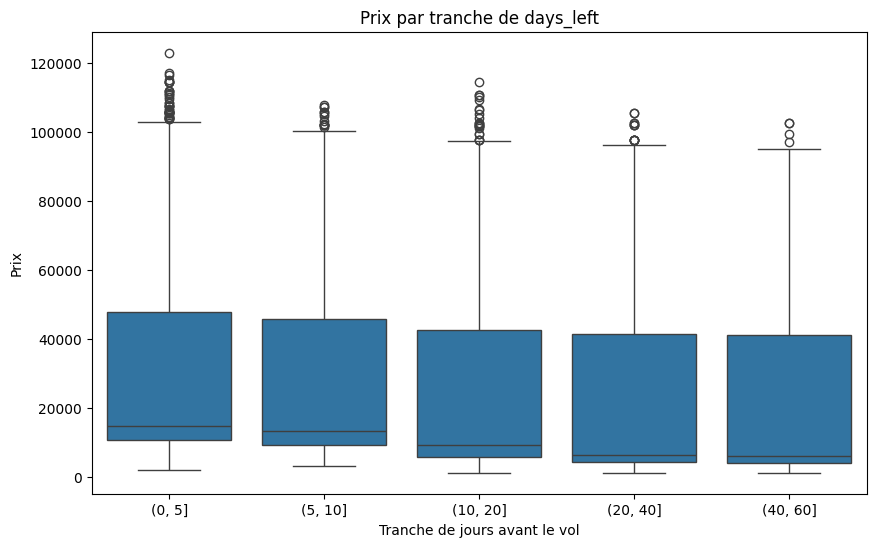

In [118]:
# On crée des tranches (bins)
original_df["days_bin"] = pd.cut(original_df["days_left"], bins=[0,5,10,20,40,60])

plt.figure(figsize=(10, 6))
sns.boxplot(data=original_df, x="days_bin", y="price")
plt.title("Prix par tranche de days_left")
plt.xlabel("Tranche de jours avant le vol")
plt.ylabel("Prix")
plt.show()

La moyenne des prix tend à diminuer avec le nombre de jours entre la réservation et le vol. Réserver plus tôt **semble** être associé à des prix plus bas.

---

<a id="formuler-et-tester-des-hypotheses"></a>

# Formuler et tester des hypothèses

Après l'analyse technique, univariée et multivariée, on va maintenant formuler des **hypothèses statistiques** et les **tester**. L’idée est de partir de nos observations précédentes et de les transformer en hypothèses, que l’on va ensuite valider ou non à l’aide de tests statistiques.

On prendra pour ces tests un seuil de signification classique de 5% (α = 0.05).

In [119]:
alpha = 0.05

À partir des graphiques et des statistiques calculées précédemment, on retient les observations suivantes :


## 1. Durée du vol vs Prix

**Question :** les vols plus longs sont-ils associés à des prix plus élevés ?

On teste ici l’existence d’une **corrélation linéaire** entre :

- `duration` (variable continue)
- `price` (variable continue)

**Hypothèses :**

- $H_0$ : la corrélation linéaire entre `duration` et `price` est nulle.  
- $H_1$ : la corrélation linéaire entre `duration` et `price` est non nulle.

On utilise le **test de Pearson**.

In [120]:
# Test de corrélation entre duration et price
corr_duration_price, p_value_duration_price = pearsonr(original_df["duration"], original_df["price"])

print("Corrélation (duration, price) :", corr_duration_price)
print("p-value :", p_value_duration_price)

if p_value_duration_price < alpha:
    print(f"→ p-value < {alpha} : on rejette H0.")
    print("Conclusion : il existe une corrélation linéaire significative entre la durée du vol et le prix.")
else:
    print(f"→ p-value ≥ {alpha} : on ne rejette pas H0.")
    print("Conclusion : on ne met pas en évidence de corrélation linéaire significative entre la durée du vol et le prix.")

Corrélation (duration, price) : 0.2042223678454273
p-value : 0.0
→ p-value < 0.05 : on rejette H0.
Conclusion : il existe une corrélation linéaire significative entre la durée du vol et le prix.


## 2. Compagnie aérienne vs Prix

**Question :** les différentes compagnies pratiquent-elles en moyenne le même niveau de prix ?

- Variable discrète : `airline` (plusieurs catégories)
- Variable continue : `price`

Pour garder des groupes suffisamment remplis, on limite l’étude aux **compagnies les plus fréquentes** dans le dataset.

**Hypothèses :**

- $H_0$ : le prix moyen des billets est le même pour toutes les compagnies considérées.  
- $H_1$ : au moins une des compagnies a un prix moyen différent des autres.

On utilise un **test d'ANOVA**.

In [121]:
# On sélectionne les N compagnies les plus fréquentes
N = 5
top_airlines = original_df["airline"].value_counts().nlargest(N).index
df_top_airlines = original_df[original_df["airline"].isin(top_airlines)]

# Construction des groupes de prix par compagnie
groups_price_by_airline = [
    df_top_airlines[df_top_airlines["airline"] == airline]["price"].values
    for airline in top_airlines
]

# Test 
f_stat_airline, p_value_airline = f_oneway(*groups_price_by_airline)

print("Compagnies étudiées :", list(top_airlines))
print("Statistique F (airline vs price) :", f_stat_airline)
print("p-value :", p_value_airline)

if p_value_airline < alpha:
    print(f"→ p-value < {alpha} : on rejette H0.")
    print("Conclusion : le prix moyen n’est pas le même pour toutes ces compagnies (au moins une se distingue).")
else:
    print(f"→ p-value ≥ {alpha} : on ne rejette pas H0.")
    print("Conclusion : on n’a pas de preuve suffisante pour dire que le prix moyen diffère entre ces compagnies.")

Compagnies étudiées : ['Vistara', 'Air_India', 'Indigo', 'GO_FIRST', 'AirAsia']
Statistique F (airline vs price) : 19643.821994114165
p-value : 0.0
→ p-value < 0.05 : on rejette H0.
Conclusion : le prix moyen n’est pas le même pour toutes ces compagnies (au moins une se distingue).


## 3. Nombre d’escales vs Prix

**Question :** le prix moyen est-il identique quel que soit le nombre d’escales ?

- Variable discrète : `stops`
- Variable continue : `price`

**Hypothèses :**

- $H_0$ : le prix moyen des billets est le même pour tous les niveaux d’escales.  
- $H_1$ : le prix moyen des billets dépend du nombre d’escales.

On utilise un **test d'ANOVA**.

In [122]:
# On s'assure que 'stops' est de type "catégoriel"/str pour bien définir les groupes et les ordonner
stops_unique = sorted(original_df["stops"].unique())
print("Valeurs de 'stops' :", stops_unique)

groups_price_by_stops = [
    original_df[original_df["stops"] == s]["price"].values
    for s in stops_unique
]

# Test 
f_stat_stops, p_value_stops = f_oneway(*groups_price_by_stops)

print("Statistique F (stops vs price) :", f_stat_stops)
print("p-value :", p_value_stops)

if p_value_stops < alpha:
    print(f"→ p-value < {alpha} : on rejette H0.")
    print("Conclusion : le prix moyen des billets dépend du nombre d’escales.")
else:
    print(f"→ p-value ≥ {alpha} : on ne rejette pas H0.")
    print("Conclusion : on n’a pas de preuve suffisante pour dire que le prix moyen varie selon le nombre d’escales.")

Valeurs de 'stops' : ['one', 'two_or_more', 'zero']
Statistique F (stops vs price) : 6477.130362486226
p-value : 0.0
→ p-value < 0.05 : on rejette H0.
Conclusion : le prix moyen des billets dépend du nombre d’escales.


## 4. Nombre de jours avant le vol vs Prix

**Question :** Réserver plus tôt est-il associé à des prix plus bas ?

On étudie la relation entre :

- `days_left` (nombre de jours entre la réservation et le vol)
- `price` (prix du billet)

**Hypothèses :**

- $H_0$ : il n’existe pas de corrélation linéaire entre `days_left` et `price`.  
- $H_1$ : il existe une corrélation linéaire entre `days_left` et `price` (par exemple, prix plus faible lorsque `days_left` augmente).

On utilise le **test de pearson**.

In [123]:
# Test de
corr_days_price, p_value_days_price = pearsonr(original_df["days_left"], original_df["price"])

print("Corrélation (days_left, price) :", corr_days_price)
print("p-value :", p_value_days_price)

if p_value_days_price < alpha:
    print(f"→ p-value < {alpha} : on rejette H0.")
    print("Conclusion : il existe une corrélation linéaire significative entre le nombre de jours avant le vol et le prix.")
    print("Interprétation possible : réserver plus tôt est effectivement associé à des prix différents (souvent plus bas).")
else:
    print(f"→ p-value ≥ {alpha} : on ne rejette pas H0.")
    print("Conclusion : on ne met pas en évidence de corrélation linéaire significative entre days_left et price.")

Corrélation (days_left, price) : -0.09194853217143849
p-value : 0.0
→ p-value < 0.05 : on rejette H0.
Conclusion : il existe une corrélation linéaire significative entre le nombre de jours avant le vol et le prix.
Interprétation possible : réserver plus tôt est effectivement associé à des prix différents (souvent plus bas).


---

<a id="preprocessing"></a>

# Preprocessing

Après l'analyse technique, univariée, multivariée, puis les tests d’hypothèses, on va maintenant préparer les données pour la modélisation.

L’objectif du preprocessing est de transformer notre dataset brut en un jeu de données exploitable par un modèle de machine learning :

- Nettoyer les valeurs aberrantes
- Encoder les variables catégorielles
- Créer éventuellement quelques features supplémentaires
- Normaliser les variables numériques
- Préparer une pipeline scikit-learn réutilisable

On part d'une copie du dataset initial.

In [124]:
df = original_df.copy()

On commence par compter le nombre de valeurs manquantes par colonne.

In [125]:
print("Nombre de NaNs par colonne :")
print(df.isna().sum())

Nombre de NaNs par colonne :
Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
duration_bin        0
days_bin            0
dtype: int64


## Encodage simple de `stops` et `class`

Avant de construire la pipeline scikit-learn, on va encoder deux variables importantes :

- `stops` : variable ordinale (zero, one, two_or_more) → 0 / 1 / 2
- `class` : Economy / Business → 0 / 1

Ces nouvelles colonnes numériques (`stops_num` et `class_num`) pourront ensuite être normalisées et utilisées comme de vraies variables numériques dans le modèle.

In [126]:
# Encodage ordinal de stops
mapping_stops = ["zero", "one", "two_or_more"]
df["stops_num"] = df["stops"].map({k: v for v, k in enumerate(mapping_stops)})  
print(df[["stops", "stops_num"]])

       stops  stops_num
0       zero          0
1       zero          0
2       zero          0
3       zero          0
4       zero          0
...      ...        ...
300148   one          1
300149   one          1
300150   one          1
300151   one          1
300152   one          1

[300153 rows x 2 columns]


In [127]:
# Encodage binaire de class
mapping_class = ["Economy", "Business"]
df["class_num"] = df["class"].map({k: v for v, k in enumerate(mapping_class)})
print(df[["class", "class_num"]])

           class  class_num
0        Economy          0
1        Economy          0
2        Economy          0
3        Economy          0
4        Economy          0
...          ...        ...
300148  Business          1
300149  Business          1
300150  Business          1
300151  Business          1
300152  Business          1

[300153 rows x 2 columns]


## Séparation features / target et train/test split

- **Target** : `price`
- **Features** : toutes les autres colonnes utiles.

On va :
1. Supprimer la colonne `flight` (identifiant peu informatif pour le modèle).
2. Supprimer les anciennes versions catégorielles de `stops` et `class` (on garde les versions numériques).
3. Séparer en X (features) et y (target).
4. Faire un `train_test_split` avec 20% des données en test.

In [128]:
# On enlève la colonne 'flight' (identifiant) et les anciennes versions de stops/class
df_model = df.drop(columns=["flight", "stops", "class"])

In [129]:
# Séparation features / target
X = df_model.drop(columns=["price"])
y = df_model["price"]

In [130]:
# Train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((240122, 12), (60031, 12))

## Définir les colonnes numériques et catégorielles (après le préprocessing simple)

On sépare les features en deux groupes :

- **Features numériques** : 
  - `duration`
  - `days_left`
  - `stops_num`
  - `class_num`

Ces variables seront imputées (si besoin) puis **standardisées** (mean=0, std=1).

- **Features catégorielles** (nominales, sans ordre) :
  - `airline`
  - `source_city`
  - `departure_time`
  - `arrival_time`
  - `destination_city`

Ces variables seront **encodées en one-hot** via `OneHotEncoder` (avec `drop="first"` pour éviter la multicolinéarité).

In [131]:
# Colonnes numériques
numeric_features = ["duration", "days_left", "stops_num", "class_num"]

In [132]:
# Colonnes catégorielles
categorical_features = ["airline", "source_city", "departure_time", 
                        "arrival_time", "destination_city"]

In [133]:
# Pipeline pour les variables numériques : ...
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

In [ ]:
# Pipeline pour les variables catégorielles : ...
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

In [135]:
# ColumnTransformer qui applique le bon traitement à chaque type de variable
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


## Préprocesseur prêt pour la modélisation

L’objet `preprocessor` contient désormais toute la logique de preprocessing :

1. **Nettoyage** (via les imputers)
2. **Encodage** des variables catégorielles (One-Hot)
3. **Normalisation** des variables numériques (StandardScaler)

Dans la partie suivante (*Modélisation*), on pourra facilement construire un modèle complet en créant une `Pipeline` :

- étape 1 : `("preprocessor", preprocessor)`
- étape 2 : `("regressor", <modèle_de_régression>)`

Par exemple, une régression linéaire, une régression Ridge, un RandomForestRegressor, etc.

Cette approche permet :
- d’éviter les fuites de données (data leakage),
- de réappliquer exactement les mêmes transformations sur les données de test,
- et plus tard, sur de nouvelles données en production.

---

<a id="Modelisation"></a>

# Modélisation

Nous avons maintenant :

- une cible : **`price`** (variable continue),
- un jeu de features prétraitées (via l’objet `preprocessor`),
- une séparation **train / test** : `X_train`, `X_test`, `y_train`, `y_test`.

Nous sommes donc dans un cadre d’**apprentissage supervisé** pour un problème de **régression**.

Dans cette section, nous allons :

1. Construire une **baseline** avec un modèle naïf (DummyRegressor)
2. Entraîner une **régression linéaire** (LinearRegression)
3. Ajouter une **régression Ridge** (modèle linéaire régularisé)
4. Tester un **modèle non linéaire** (RandomForestRegressor)
5. Comparer les performances de tous ces modèles
6. Illustrer le réglage d’**hyperparamètres** avec `GridSearchCV`

In [136]:
# Petite fonction utilitaire pour évaluer un modèle
def evaluate_model(
    name,
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    results_dict,
    cv=5,
):
    """
    Évalue un modèle avec validation croisée sur le train,
    puis refit sur tout le train et évalue une fois sur le test.

    Paramètres
    ----------
    name : str
        Nom du modèle (pour l'affichage et le dictionnaire de résultats).
    model : estimator / Pipeline
        Modèle ou Pipeline scikit-learn (déjà construit).
    X_train, y_train : array-like
        Données d'entraînement.
    X_test, y_test : array-like
        Données de test.
    results_dict : dict
        Dictionnaire dans lequel on stocke les résultats.
    cv : int
        Nombre de folds pour la validation croisée.
    """

    # ----- 1) Validation croisée sur le train -----
    cv_results = cross_validate(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=KFold(n_splits=cv, shuffle=True, random_state=42),
        scoring={
            "mae": "neg_mean_absolute_error",
            "rmse": "neg_root_mean_squared_error",
            "r2": "r2",
        },
    )

    # Moyennes (on remet les signes positifs pour MAE / RMSE)
    cv_mae_mean = -cv_results["test_mae"].mean()
    cv_mae_std  =  cv_results["test_mae"].std()

    cv_rmse_mean = -cv_results["test_rmse"].mean()
    cv_rmse_std  =  cv_results["test_rmse"].std()

    cv_r2_mean = cv_results["test_r2"].mean()
    cv_r2_std  = cv_results["test_r2"].std()

    print(f"=== {name} ===")
    print(f"Validation croisée ({cv}-fold) sur le train :")
    print(f"  MAE  (mean ± std) : {cv_mae_mean:.2f} ± {cv_mae_std:.2f}")
    print(f"  RMSE (mean ± std) : {cv_rmse_mean:.2f} ± {cv_rmse_std:.2f}")
    print(f"  R²   (mean ± std) : {cv_r2_mean:.4f} ± {cv_r2_std:.4f}")

    # ----- 2) Refit sur tout le train -----
    model.fit(X_train, y_train)

    # ----- 3) Évaluation finale sur le test -----
    y_test_pred = model.predict(X_test)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print("Évaluation finale sur le test :")
    print(f"  Test MAE  : {test_mae:.2f}")
    print(f"  Test RMSE : {test_rmse:.2f}")
    print(f"  Test R²   : {test_r2:.4f}")
    print()

    results_dict[name] = {
        "cv_mae_mean": cv_mae_mean,
        "cv_mae_std": cv_mae_std,
        "cv_rmse_mean": cv_rmse_mean,
        "cv_rmse_std": cv_rmse_std,
        "cv_r2_mean": cv_r2_mean,
        "cv_r2_std": cv_r2_std,
        "test_mae": test_mae,
        "test_rmse": test_rmse,
        "test_r2": test_r2,
    }

In [137]:
# Dictionnaire pour stocker les résultats de tous les modèles
results = {}

## 1. Baseline  DummyRegressor

Avant d’entraîner de “vrais” modèles de Machine Learning, on commence par une **baseline naïve**.

On utilise ici un `DummyRegressor` qui prédit toujours la **moyenne** des prix observés sur le jeu d’entraînement.

Ce modèle :
- ne regarde pas les features,
- sert uniquement de **référence** : un bon modèle doit faire mieux que lui.

In [138]:
dummy_model = DummyRegressor(strategy='mean')

evaluate_model(
    name="DummyRegressor (mean)",
    model=dummy_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    results_dict=results,
)

=== DummyRegressor (mean) ===
Validation croisée (5-fold) sur le train :
  MAE  (mean ± std) : 19757.22 ± 35.06
  RMSE (mean ± std) : 22696.11 ± 47.23
  R²   (mean ± std) : -0.0000 ± 0.0000
Évaluation finale sur le test :
  Test MAE  : 19768.69
  Test RMSE : 22704.24
  Test R²   : -0.0000



## 2. Régression linéaire  `LinearRegression`

On passe maintenant à un premier “vrai” modèle de Machine Learning : la **régression linéaire**.

Pour l’utiliser proprement avec nos données :

- On intègre le **preprocessing** (encodage + normalisation) dans une `Pipeline`.
- On ajoute ensuite un estimateur `LinearRegression`.

La `Pipeline` permet de :

- `fit` le préprocesseur uniquement sur le **train**,
- appliquer exactement les mêmes transformations sur le **test**,
- éviter les fuites de données (data leakage).

In [139]:
linreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

evaluate_model(
    name="LinearRegression",
    model=linreg_pipeline,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    results_dict=results,
)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 655, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 589, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 996, in fit_transform
    result = self._call_func_on_transformers(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 897, in _call_func_on_transformers
    return Parallel(n_jobs=self.n_jobs)(jobs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py", line 82, in __call__
    return super().__call__(iterable_with_config_and_warning_filters)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/joblib/parallel.py", line 1986, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/joblib/parallel.py", line 1914, in _get_sequential_output
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py", line 147, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 719, in fit_transform
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 589, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/base.py", line 897, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py", line 452, in fit
    X = self._validate_input(X, in_fit=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py", line 377, in _validate_input
    raise new_ve from None
ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'Air_India'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 655, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 589, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 996, in fit_transform
    result = self._call_func_on_transformers(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 897, in _call_func_on_transformers
    return Parallel(n_jobs=self.n_jobs)(jobs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py", line 82, in __call__
    return super().__call__(iterable_with_config_and_warning_filters)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/joblib/parallel.py", line 1986, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/joblib/parallel.py", line 1914, in _get_sequential_output
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/utils/parallel.py", line 147, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 719, in fit_transform
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 589, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/base.py", line 897, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py", line 452, in fit
    X = self._validate_input(X, in_fit=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stephane/Projects/Projet_flight_price/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py", line 377, in _validate_input
    raise new_ve from None
ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'Indigo'


## 3. Régression linéaire régularisée  `Ridge`

La régression linéaire classique peut parfois :

- mal généraliser,
- être sensible aux colinéarités entre features.

La **régression Ridge** ajoute une **pénalité L2** sur la taille des coefficients, contrôlée par un hyperparamètre `alpha` :

- `alpha` petit → peu de régularisation (proche de LinearRegression)
- `alpha` grand → coefficients plus “petits”, modèle plus régularisé

On va commencer par tester quelques valeurs de `alpha` “à la main”, sans GridSearch, pour voir l’impact sur les performances.

In [ ]:
alphas = ...

for a in alphas:
    ridge_pipeline = ...
    
    evaluate_model(
        name=f"Ridge (alpha={a})",
        model=ridge_pipeline,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        results_dict=results,
    )

## 4. Modèle non linéaire  `RandomForestRegressor`

Pour capturer des relations **non linéaires** entre les variables et le prix, on peut utiliser une **forêt aléatoire de régression** (`RandomForestRegressor`).

Principe :

- on entraîne plusieurs **arbres de décision** sur des sous-échantillons des données,
- on moyenne leurs prédictions,
- le modèle est souvent robuste et performant sur des données tabulaires.

Hyperparamètres importants :

- `n_estimators` : nombre d’arbres,
- `max_depth` : profondeur maximale des arbres,
- `min_samples_leaf` : nombre minimum d’échantillons dans une feuille.

On commence avec des valeurs “raisonnables” et les hyperparamètres par défaut pour les autres. 

Temps d’entraînement plus long, mais souvent de bonnes performances (environ 5 minutes).

In [ ]:
rf_pipeline = ...

evaluate_model(
    name="RandomForestRegressor",
    model=rf_pipeline,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    results_dict=results,
)

## 5. Comparaison des modèles

On regroupe maintenant les résultats de tous les modèles testés dans un tableau récapitulatif.

On compare en particulier :

- la **baseline** (DummyRegressor),
- la **régression linéaire**,
- la **régression Ridge** pour différentes valeurs de `alpha`,
- la **Random Forest**.

Les métriques regardées :

- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- R² (coefficient de détermination)

L’objectif est de voir :

- quels modèles généralisent le mieux (bon score sur le test),
- s’il y a de l’overfitting (écart train/test important),
- et lequel on retiendrait comme modèle “principal” pour ce projet.

In [ ]:
results_df = pd.DataFrame(results).T

results_df = ...

results_df

Ici, le meilleur modèle est clairement le **RandomForestRegressor**, qui capture bien les relations non linéaires et les interactions entre variables. 

On passe maintenant à l'entrainement du modèle final sur l'ensemble des données d'entrainement.

In [ ]:
best_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=1,
        random_state=42,
    ))
])

best_model.fit(X_train, y_train)

<a id="evaluation-finale-du-modele"></a>

# Évaluation finale du modèle

In [ ]:
y_test_pred = best_model.predict(X_test)

mae = ...
rmse = ...
r2 = ...

In [ ]:
print(f"Test MAE  : {mae:.2f}")
print(f"Test RMSE : {rmse:.2f}")
print(f"Test R²   : {r2:.4f}")

On obtient les performances finales du modèle sur le jeu de test.

## Intervalle de confiance sur la MAE

In [ ]:
import numpy as np

# Prédictions
y_test_pred = best_model.predict(X_test)

# Erreurs absolues (une par observation)
abs_errors = np.abs(y_test.to_numpy() - y_test_pred)

# MAE = moyenne des erreurs absolues
mae = abs_errors.mean()

# Écart-type (std) des erreurs absolues
sigma = abs_errors.std(ddof=1)  # ddof=1 -> écart-type "échantillon"

# Erreur standard (SE)
n = len(abs_errors)
se = ...

# z-score (95% = 1.96)
z = 1.96

# Intervalle de confiance
ci_low = ...
ci_high = ...

print(f"n = {n}")
print(f"MAE = {mae:.2f}")
print(f"std(|erreur|) = {sigma:.2f}")
print(f"SE = {se:.4f}")
print(f"IC 95% : [{ci_low:.2f}, {ci_high:.2f}]")

Sur l’échantillon de test, la MAE vaut $1086.89$ INR. En construisant un intervalle de confiance à 95% suivant la formule : $$[\text{MAE}-z\cdot\text{SE}; \text{MAE}+z\cdot\text{SE}]$$

On obtient $$[1066.24 ; 1107.55]$$

Cela indique que, compte tenu de la taille finie du test, l’erreur moyenne “vraie” attendue en généralisation devrait se situer dans cette fourchette, avec une incertitude d’environ ±20.7 INR autour de la MAE observée.

L’objectif est atteint : la MAE estimée est d’environ 10€, et l’intervalle de confiance à 95% reste entièrement sous le seuil de 15 €. 
En euros on a : $$[10.07 ; 10.46]$$

# Export du modèle final avec le préprocesseur intégré dans une pipeline.

In [ ]:
import joblib
from pathlib import Path
from datetime import datetime
import json

# best_model est déjà une Pipeline scikit-learn : ("preprocessor" -> ColumnTransformer) + ("model" -> RandomForestRegressor)
# et il est déjà fit sur X_train, y_train

ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True, parents=True)

MODEL_PATH = ARTIFACT_DIR / "flight_price_model.joblib"
META_PATH  = ARTIFACT_DIR / "flight_price_model.meta.json"

joblib.dump(best_model, MODEL_PATH)

metadata = {
    "created_at": datetime.now().isoformat(timespec="seconds"),
    "artifact": str(MODEL_PATH),
    "target": "price",
    "expected_features": [
        "airline", "source_city", "departure_time", "arrival_time", "destination_city",
        "duration", "days_left", "stops_num", "class_num"
    ],
    "notes": "Pipeline scikit-learn (preprocessor + model). Utiliser .predict() directement."
}
META_PATH.write_text(json.dumps(metadata, indent=2), encoding="utf-8")

print("Modèle exporté :", MODEL_PATH)
print("Métadonnées :", META_PATH)